# HArmful brain-activities

This notebook aims to develop a model to classify harmful five types of harmful brain activities, (seizure, generalized periodic discharges, lateralized periodic discharges, lateralized rhythmic delta activity, generalized rhythmic delta activity). The data are imported from Kaggle ("HMS - Harmful Brain Activity Classification" competition). The model aims to classify the brain activities given 50 seconds EEGs and 10 minutes spectograms. For more info: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification

In [1]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as transforms

import cv2
import pandas as pd

import joblib

from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [2]:
import os

BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"


In the next cell we will import the data and seperates them to trainning and testing sets.


In [3]:
df_total = pd.read_csv(f'{BASE_PATH}/train.csv')
pr= np.random.rand(len(df_total))
df_train=df_total[pr>0.3].reset_index(drop=True)
df_test=df_total[pr<0.3].reset_index(drop=True)


Here we define the 4 spectograms, one for each part of the brain. We define the 20 EEGs. And we normalize the data using the log function.

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        spec_id = self.df['spectrogram_id'][idx]
        eeg_id = self.df['eeg_id'][idx]
        eeg_offset = (self.df['eeg_label_offset_seconds'][idx]).astype(np.int64)
   
        a=pd.read_parquet(f"{BASE_PATH}/train_spectrograms/{spec_id}.parquet" )
        spec_offset = (self.df['spectrogram_label_offset_seconds'][idx]//2).astype(np.int64)
        a=a[spec_offset:spec_offset+300]
        
        a_LL=torch.tensor(a.filter(regex='^LL').values)
        a_RL=torch.tensor(a.filter(regex='^RL').values)
        a_RP=torch.tensor(a.filter(regex='^RP').values)
        a_LP=torch.tensor(a.filter(regex='^LP').values)
    
        a_LL = torch.log(torch.nan_to_num(a_LL) +1)
        a_RL = torch.log(torch.nan_to_num(a_RL) +1)
        a_RP = torch.log(torch.nan_to_num(a_RP) +1)
        a_LP = torch.log(torch.nan_to_num(a_LP) +1)
        A = torch.stack([a_LL, a_RL, a_RP, a_LP], dim=0)
        
        b=pd.read_parquet(f"{BASE_PATH}/train_eegs/{eeg_id}.parquet" )
        b=torch.tensor(b.values)[eeg_offset:eeg_offset+50*200,:]
        b = torch.log(b**2 + 1)
        #b = torch.tensor(np.load(os.path.join(SPEC_DIR+'/treatt_eeg', str(idx) + '.npy' )) )
        
        s=(self.df.iloc[idx, 9:].values).astype(float)
        #print(s)
        s=s/sum(s)
        b= b.float() 
        s= torch.tensor(s).float()
        
        A[torch.isnan(A)] = 0
        b[torch.isnan(b)] = 0
        s[torch.isnan(s)] = 0
 
        return A,b,s

In [5]:


def collate_fn(batch):


    T, E, targets = [], [] , []

    # Gather in lists, and encode labels as indices
    for A,eeg, label  in batch:

        T += [A.permute(0, 2, 1)]
        E += [eeg.permute(1, 0)]
        targets += [label]#[label_to_index(label)]

    # Group the list of tensors into a batched tensor
    T = torch.stack(T)
    E = torch.stack(E)
    targets = torch.stack(targets)

    return T, E, targets

In [6]:
training_data=CustomImageDataset(df_train)
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True, collate_fn=collate_fn)

test_data=CustomImageDataset(df_test)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True, collate_fn=collate_fn)


In [7]:
T, E, labels = next(iter(train_dataloader))

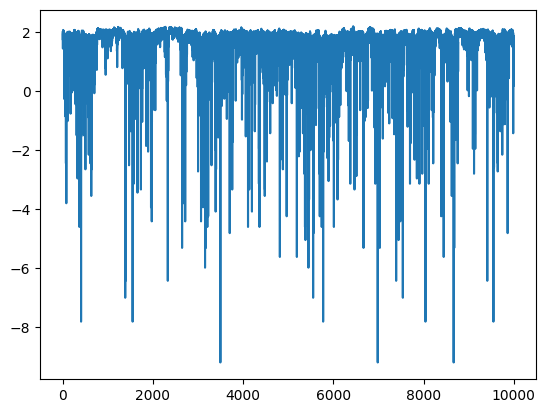

In [8]:
plt.plot(torch.log(abs(E[4,0,:])))

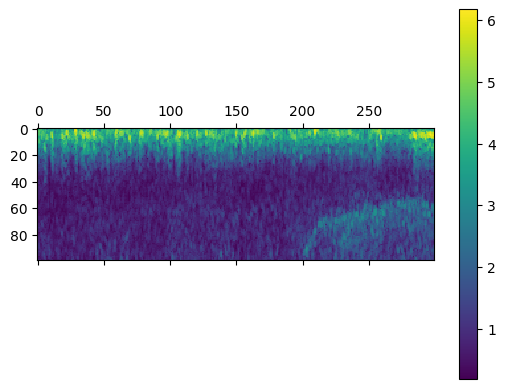

In [9]:
fig, ax = plt.subplots()

# Plot the matrix
cax = ax.matshow(T[1][0][:,:], cmap='viridis')

# Add a colorbar
fig.colorbar(cax)

# Display the plot
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights


# The model:
The input of the model are 4 spectograms, which are a $400 \times 300$ matrix, and 20 EEGs which are $10 000$ long vectors. The spectograms are treated with a pretrained CNN convolution network (resnet 18), where we change the the first convolution layer (a convolution layer with 4 input channels), and the output of the network is a $[1\times 100]$ long vector $y_1$. \\
The EEGs are treated with a 1D convolution neural network, where the output is a $[1\times 100]$ long vector $y_2$.
The two vectors $y_1$ and $y_2$ are then passed through a shallow feedforward neural network.

In [12]:
m_spec = models.resnet18(weights=ResNet18_Weights.DEFAULT)
m_spec.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
m_spec.fc = nn.Linear(512, 100)
m_spec=m_spec.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.8MB/s]


In [13]:
class Meeg(nn.Module):
    def __init__(self, n_input=4, n_output=6, stride=3, n_channel=64):
        super().__init__()
        self.conv1 = nn.Conv1d(20, n_channel, kernel_size=(30), stride=(5))
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(n_channel, 2*n_channel, kernel_size=(30), stride=(5))
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(2*n_channel, 2 * n_channel, kernel_size=(30), stride=(5))
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(2)

        
        self.fc1 = nn.Linear(2 * n_channel, 100)
        self.fc2 = nn.Linear(100, 100)
        
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 6)

        
    def forward(self, x,y):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x=x.permute(0,2,1)
        x=torch.mean(x,1)


        x = self.fc1(x)
        x = self.fc2(x+y)
        x = self.fc3(x)
        x = self.fc4(x)

   
        return x


m_eeg = Meeg(n_input=4, n_output=6)
m_eeg.to(device)
#print(model)




Meeg(
  (conv1): Conv1d(20, 64, kernel_size=(30,), stride=(5,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(30,), stride=(5,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 128, kernel_size=(30,), stride=(5,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)

In [14]:
def for_pass(E,T):
    y=m_spec(T)
    return m_eeg(E,y) 

In [16]:
kl_loss = nn.CrossEntropyLoss()
def train(m_spec,m_eeg, epoch, log_interval):
    m_spec.train()
    m_eeg.train()
    for batch_idx, (spec,eeg, target) in enumerate(train_dataloader):
        
        spec = spec.to(device)
        eeg = eeg.to(device)
        target = target.to(device)
                
        output = for_pass(eeg,spec)

        loss = kl_loss(output.squeeze(), target.squeeze())
        if torch.isnan(loss):
            print('break')
            break
            

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(eeg)}/{len(train_dataloader.dataset)} ({100. * batch_idx / len(train_dataloader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())
        clear_cuda_memory()
        gc.collect()

In [17]:
import gc

def clear_cuda_memory():
    gc.collect()
    torch.cuda.empty_cache()
clear_cuda_memory()


The models are trained for 1 epoch

In [18]:
params = list(m_spec.parameters()) + list(m_eeg.parameters())
optimizer = optim.Adam(params, lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

from tqdm import tqdm

log_interval = 20
n_epoch = 1

pbar_update = 1 / (len(train_dataloader) )
losses = []

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(m_spec,m_eeg, epoch, log_interval)
        #test(model, epoch)
        scheduler.step()
        

  0%|          | 0.0017094017094017094/1 [00:12<2:06:12, 7585.32s/it]

Train Epoch: 1 [0/74815 (0%)]	Loss: 1.840576


  4%|▎         | 0.03589743589743591/1 [04:22<2:08:20, 7987.60s/it]  

Train Epoch: 1 [2560/74815 (3%)]	Loss: 1.320100


  7%|▋         | 0.07008547008547009/1 [08:21<1:41:45, 6566.17s/it]

Train Epoch: 1 [5120/74815 (7%)]	Loss: 1.199706


 10%|█         | 0.10427350427350415/1 [11:40<1:17:58, 5222.86s/it]

Train Epoch: 1 [7680/74815 (10%)]	Loss: 1.144393


 14%|█▍        | 0.13846153846153822/1 [14:31<1:10:56, 4940.10s/it]

Train Epoch: 1 [10240/74815 (14%)]	Loss: 1.008455


 17%|█▋        | 0.17264957264957229/1 [17:13<1:06:37, 4832.25s/it]

Train Epoch: 1 [12800/74815 (17%)]	Loss: 0.977309


 21%|██        | 0.20683760683760635/1 [19:52<1:01:36, 4659.98s/it]

Train Epoch: 1 [15360/74815 (21%)]	Loss: 1.053740


 24%|██▍       | 0.24102564102564042/1 [22:29<57:46, 4567.58s/it]  

Train Epoch: 1 [17920/74815 (24%)]	Loss: 1.035283


 28%|██▊       | 0.2752136752136745/1 [25:07<1:00:01, 4969.07s/it]

Train Epoch: 1 [20480/74815 (27%)]	Loss: 0.875626


 31%|███       | 0.3094017094017086/1 [27:40<51:11, 4447.89s/it]  

Train Epoch: 1 [23040/74815 (31%)]	Loss: 0.783965


 34%|███▍      | 0.34358974358974265/1 [30:12<48:30, 4434.61s/it]

Train Epoch: 1 [25600/74815 (34%)]	Loss: 0.790517


 38%|███▊      | 0.3777777777777767/1 [32:41<46:01, 4438.82s/it] 

Train Epoch: 1 [28160/74815 (38%)]	Loss: 0.866483


 41%|████      | 0.4119658119658108/1 [35:12<43:25, 4431.54s/it] 

Train Epoch: 1 [30720/74815 (41%)]	Loss: 0.756686


 45%|████▍     | 0.44615384615384485/1 [37:41<39:55, 4325.74s/it]

Train Epoch: 1 [33280/74815 (44%)]	Loss: 0.764534


 48%|████▊     | 0.4803418803418789/1 [40:10<38:25, 4435.88s/it] 

Train Epoch: 1 [35840/74815 (48%)]	Loss: 0.834887


 51%|█████▏    | 0.514529914529913/1 [42:36<34:38, 4280.68s/it]  

Train Epoch: 1 [38400/74815 (51%)]	Loss: 0.734544


 55%|█████▍    | 0.5487179487179471/1 [45:01<31:58, 4250.17s/it]

Train Epoch: 1 [40960/74815 (55%)]	Loss: 0.752514


 58%|█████▊    | 0.5829059829059812/1 [47:26<29:33, 4251.81s/it]

Train Epoch: 1 [43520/74815 (58%)]	Loss: 0.769965


 62%|██████▏   | 0.6170940170940152/1 [49:49<27:01, 4233.54s/it]

Train Epoch: 1 [46080/74815 (62%)]	Loss: 0.829780


 65%|██████▌   | 0.6512820512820493/1 [52:16<25:06, 4319.09s/it]

Train Epoch: 1 [48640/74815 (65%)]	Loss: 0.676048


 69%|██████▊   | 0.6854700854700834/1 [54:38<22:17, 4251.86s/it]

Train Epoch: 1 [51200/74815 (68%)]	Loss: 0.754794


 72%|███████▏  | 0.7196581196581174/1 [57:03<19:24, 4152.94s/it]

Train Epoch: 1 [53760/74815 (72%)]	Loss: 0.663010


 75%|███████▌  | 0.7538461538461515/1 [59:24<17:03, 4156.07s/it]

Train Epoch: 1 [56320/74815 (75%)]	Loss: 0.680708


 79%|███████▉  | 0.7880341880341856/1 [1:01:47<14:53, 4217.51s/it]

Train Epoch: 1 [58880/74815 (79%)]	Loss: 0.748068


 82%|████████▏ | 0.8222222222222196/1 [1:04:10<12:20, 4163.67s/it]

Train Epoch: 1 [61440/74815 (82%)]	Loss: 0.746228


 86%|████████▌ | 0.8564102564102537/1 [1:06:31<09:59, 4176.15s/it]

Train Epoch: 1 [64000/74815 (85%)]	Loss: 0.636430


 89%|████████▉ | 0.8905982905982878/1 [1:08:52<07:34, 4155.86s/it]

Train Epoch: 1 [66560/74815 (89%)]	Loss: 0.734325


 92%|█████████▏| 0.9247863247863218/1 [1:11:15<05:19, 4252.83s/it]

Train Epoch: 1 [69120/74815 (92%)]	Loss: 0.784436


 96%|█████████▌| 0.9589743589743559/1 [1:13:39<02:49, 4131.04s/it]

Train Epoch: 1 [71680/74815 (96%)]	Loss: 0.649822


 99%|█████████▉| 0.99316239316239/1 [1:16:01<00:28, 4221.41s/it]  

Train Epoch: 1 [74240/74815 (99%)]	Loss: 0.627770


100%|█████████▉| 0.9999999999999968/1 [1:16:27<00:00, 4587.40s/it]


In [28]:
df_test.shape

(32084, 15)

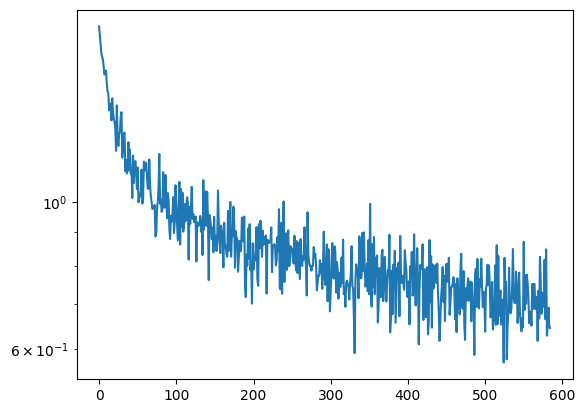

In [19]:
plt.semilogy(losses)

The model is tested on the testing data (unseen during training), the accuracy is measured by the most likely predicted brain activity, vs the brain activity that received the most votes

In [23]:
T, E,targets = next(iter(test_dataloader))

In [24]:
acc=[]
#T[1:8].unsqueeze(1).to(device)
p=torch.softmax(for_pass(E.to(device),T.to(device)).cpu(),dim=1)

for j in range(len(T)):
    isit = torch.where(targets[j]==max(targets[j]))[0][0] == torch.where(p[j]==max(p[j]))[0][0]
    acc.append(isit)

In [35]:
accuracy = sum(acc)/len(acc)
print('accuracy =', accuracy.item())

accuracy = 0.8203125
